In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer,KNNImputer,IterativeImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
def Wrangle(dataframe_path, remove_outliers=True):
    df = pd.read_csv(dataframe_path)

    if remove_outliers:
        outlier_cols = ['Insulin', 'SkinThickness']  # These often have extreme values
        for col in outlier_cols:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                df = df[~((df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR)))]

    return df


In [3]:
def initial_exploration(data_frame):
    """Comprehensive initial data exploration"""
    print(f"Dataset shape: {data_frame.shape}")
    print("\nBasic statistics:")
    print(data_frame.describe().transpose())
    print("\nColumn data types:")
    print(data_frame.dtypes)
    print("\nMissing values:")
    print(data_frame.isnull().sum())

    if 'Outcome' in data_frame.columns:
        print("\nClass distribution:")
        print(data_frame['Outcome'].value_counts(normalize=True))
        class_counts = data_frame['Outcome'].value_counts()
        print(f"Class imbalance ratio: {class_counts[0]/class_counts[1]:.2f}")

In [4]:
df=Wrangle("diabetes.csv")
df.head()
initial_exploration(df)


Dataset shape: (733, 9)

Basic statistics:
                          count        mean        std     min     25%  \
Pregnancies               733.0    3.844475   3.384768   0.000   1.000   
Glucose                   733.0  119.076398  31.155123   0.000  99.000   
BloodPressure             733.0   68.989086  19.626844   0.000  62.000   
SkinThickness             733.0   19.877217  15.692875   0.000   0.000   
Insulin                   733.0   62.413370  79.153028   0.000   0.000   
BMI                       733.0   31.850205   7.924103   0.000  27.100   
DiabetesPedigreeFunction  733.0    0.466771   0.322261   0.078   0.243   
Age                       733.0   33.145975  11.674278  21.000  24.000   
Outcome                   733.0    0.338336   0.473466   0.000   0.000   

                              50%      75%     max  
Pregnancies                 3.000    6.000   17.00  
Glucose                   115.000  137.000  199.00  
BloodPressure              72.000   80.000  122.00  
Skin

In [5]:
def zeros_to_nan(df):
    """
    Replace zeros with NaN for columns where zero is biologically impossible
    Returns cleaned dataframe and reports zero statistics
    """
    print("Zero values in columns where 0 is impossible:")
    zero_stats = {}
    impossible_zero_cols= ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    cleaned_df = df.copy()
    for col in impossible_zero_cols:
        if col in df.columns:
            zero_count = (df[col] == 0).sum()
            zero_percentage = (zero_count / len(df)) * 100
            zero_stats[col] = zero_count
            print(f"{col}: {zero_count} ({zero_percentage:.1f}%)")
            cleaned_df[col] = cleaned_df[col].replace(0, np.nan)

    print("\nMissing values after replacing zeros:")
    print(cleaned_df[impossible_zero_cols].isnull().sum())

    return cleaned_df, zero_stats




In [6]:
zeros_to_nan(df)

Zero values in columns where 0 is impossible:
Glucose: 5 (0.7%)
BloodPressure: 35 (4.8%)
SkinThickness: 227 (31.0%)
Insulin: 373 (50.9%)
BMI: 11 (1.5%)

Missing values after replacing zeros:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          373
BMI               11
dtype: int64


(     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0              6    148.0           72.0           35.0      NaN  33.6   
 1              1     85.0           66.0           29.0      NaN  26.6   
 2              8    183.0           64.0            NaN      NaN  23.3   
 3              1     89.0           66.0           23.0     94.0  28.1   
 4              0    137.0           40.0           35.0    168.0  43.1   
 ..           ...      ...            ...            ...      ...   ...   
 763           10    101.0           76.0           48.0    180.0  32.9   
 764            2    122.0           70.0           27.0      NaN  36.8   
 765            5    121.0           72.0           23.0    112.0  26.2   
 766            1    126.0           60.0            NaN      NaN  30.1   
 767            1     93.0           70.0           31.0      NaN  30.4   
 
      DiabetesPedigreeFunction  Age  Outcome  
 0                       0.627   50        1  
 1  

In [7]:
def handle_missing_values(df, strategy='iterative', min_values=None):
    """Enhanced imputation with strict biological constraints"""
    df_imputed = df.copy()
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    if 'Outcome' in numerical_cols:
        numerical_cols = numerical_cols.drop('Outcome')

    # Set conservative medical minimums (adjust based on your clinical knowledge)
    default_mins = {
        'Glucose': 50,        # Revised from 20 to be more conservative
        'BloodPressure': 40,   # Diastolic can't realistically be lower
        'SkinThickness': 5,
        'Insulin': 14,
        'BMI': 12
    }
    min_values = min_values or default_mins

    # Two-stage imputation with constraints
    if strategy == 'iterative':
        imputer = IterativeImputer(
            max_iter=30,
            random_state=42,
            min_value=[min_values.get(col, -np.inf) for col in numerical_cols],
            skip_complete=True
        )
    else:
        # First pass imputation
        if strategy == 'knn':
            imputer = KNNImputer(n_neighbors=5)
        else:
            imputer = SimpleImputer(strategy=strategy)

    df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])

    # Second pass: enforce hard constraints
    for col, min_val in min_values.items():
        if col in df_imputed.columns:
            # Replace any values below threshold with the minimum + small noise
            mask = df_imputed[col] < min_val
            if mask.any():
                print(f"Correcting {mask.sum()} values in {col} below minimum")
                noise = np.random.uniform(0, min_val*0.1, size=mask.sum())
                df_imputed.loc[mask, col] = min_val + noise

    # Final validation
    failed_cols = []
    for col, min_val in min_values.items():
        if col in df_imputed.columns:
            if any(df_imputed[col] < min_val):
                failed_cols.append(col)

    if failed_cols:
        print("\nWarning: Some columns still contain implausible values:")
        for col in failed_cols:
            min_found = df_imputed[col].min()
            print(f"- {col}: min value {min_found:.2f} (threshold {min_values[col]})")

        # Option 1: Force correction
        print("\nApplying forced correction...")
        for col in failed_cols:
            df_imputed[col] = np.maximum(df_imputed[col], min_values[col])

    print("\nFinal missing values:", df_imputed.isnull().sum().sum())
    return df_imputed

In [8]:
df=handle_missing_values(df)
df.head()

Correcting 6 values in Glucose below minimum
Correcting 39 values in BloodPressure below minimum
Correcting 227 values in SkinThickness below minimum
Correcting 373 values in Insulin below minimum
Correcting 11 values in BMI below minimum

Final missing values: 0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.00000,14.385681,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.00000,14.210107,26.6,0.351,31.0,0
2,8.0,183.0,64.0,5.45833,15.248268,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.00000,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.00000,168.000000,43.1,2.288,33.0,1


In [9]:
def EDA_BoxPlots(df):
    numeric_cols = df.select_dtypes("number").columns

    # Calculate rows/cols for subplots
    n_cols = 3
    n_rows = (len(numeric_cols) // n_cols + 1)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(col)
    for j in range(i + 1, len(axes)):
          axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

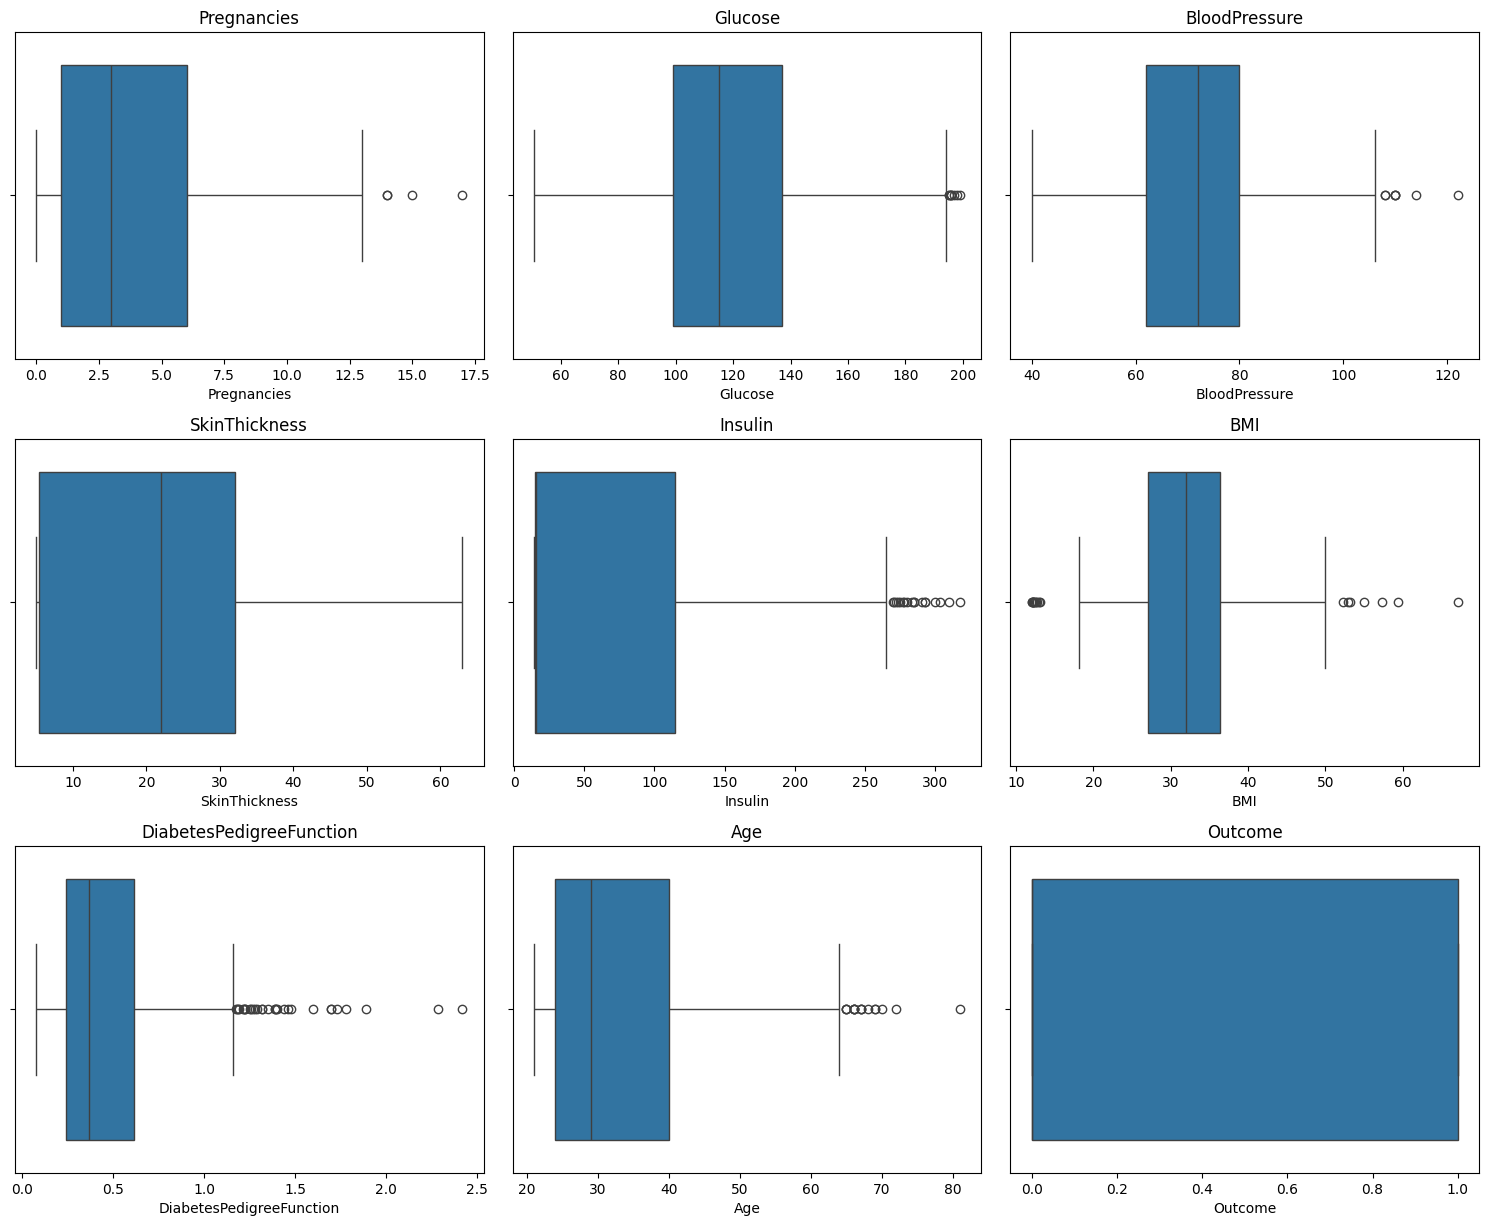

In [10]:
EDA_BoxPlots(df)

In [11]:
def EDA_Hist(df):
  num_cols=df.select_dtypes("number").columns
  n_cols=3
  n_rows=(len(num_cols) // n_cols + 1)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
  axes=axes.flatten()
  for i,col in enumerate(num_cols):
    sns.histplot(data=df,x=col,ax=axes[i])
    axes[i].set_title(col)
  for i in range(i+1,len(axes)):
    axes[i].set_visible(False)

  plt.tight_layout()
  plt.show()

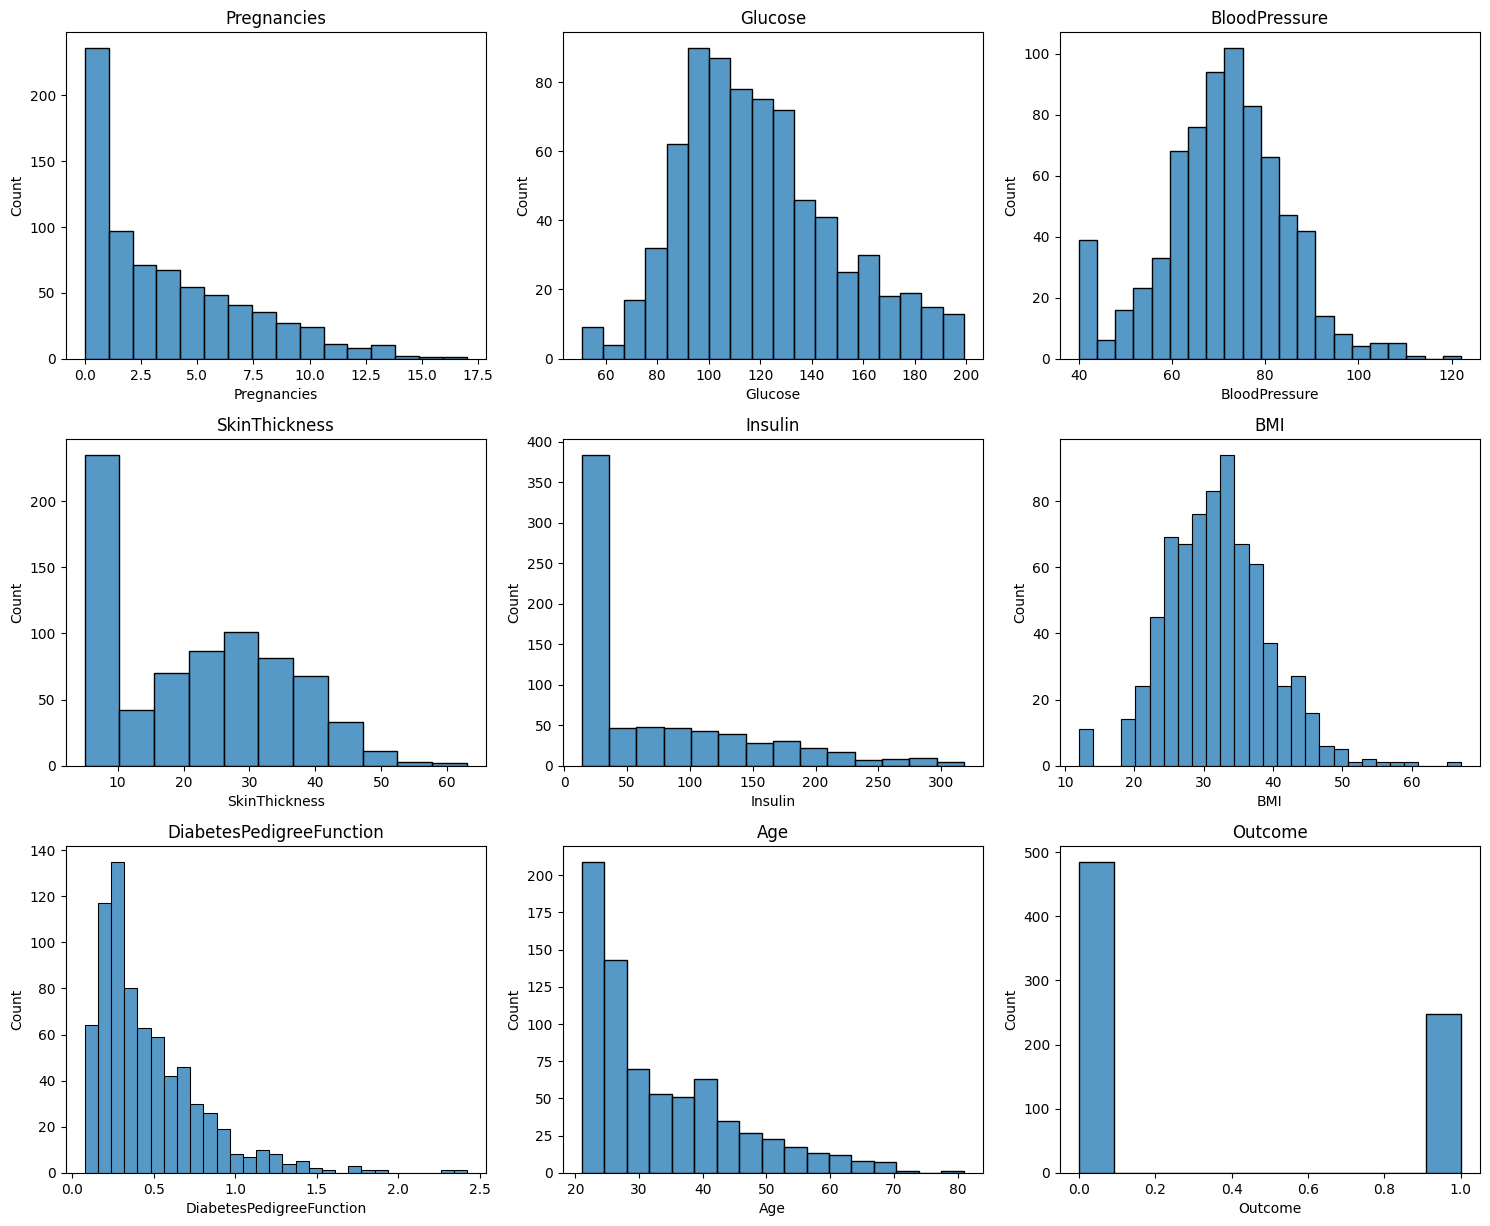

In [12]:
EDA_Hist(df)

In [13]:
def EDA_scatterPlots(df):
  num_cols=df.drop("Outcome",axis=1).select_dtypes("number").columns
  n_cols=3
  n_rows=(len(num_cols) // n_cols + 1)
  fig,axes=plt.subplots(n_rows,n_cols,figsize=(15,n_rows*4))
  axes=axes.flatten()
  for i,col in enumerate(num_cols):
    sns.scatterplot(data=df,x="Outcome",y=col,ax=axes[i])
    axes[i].set_title(f"{col}Vs.Outcome")
  for j in range(i+1,len(axes)):
    axes[j].set_visible(False)
  plt.tight_layout()
  plt.show()

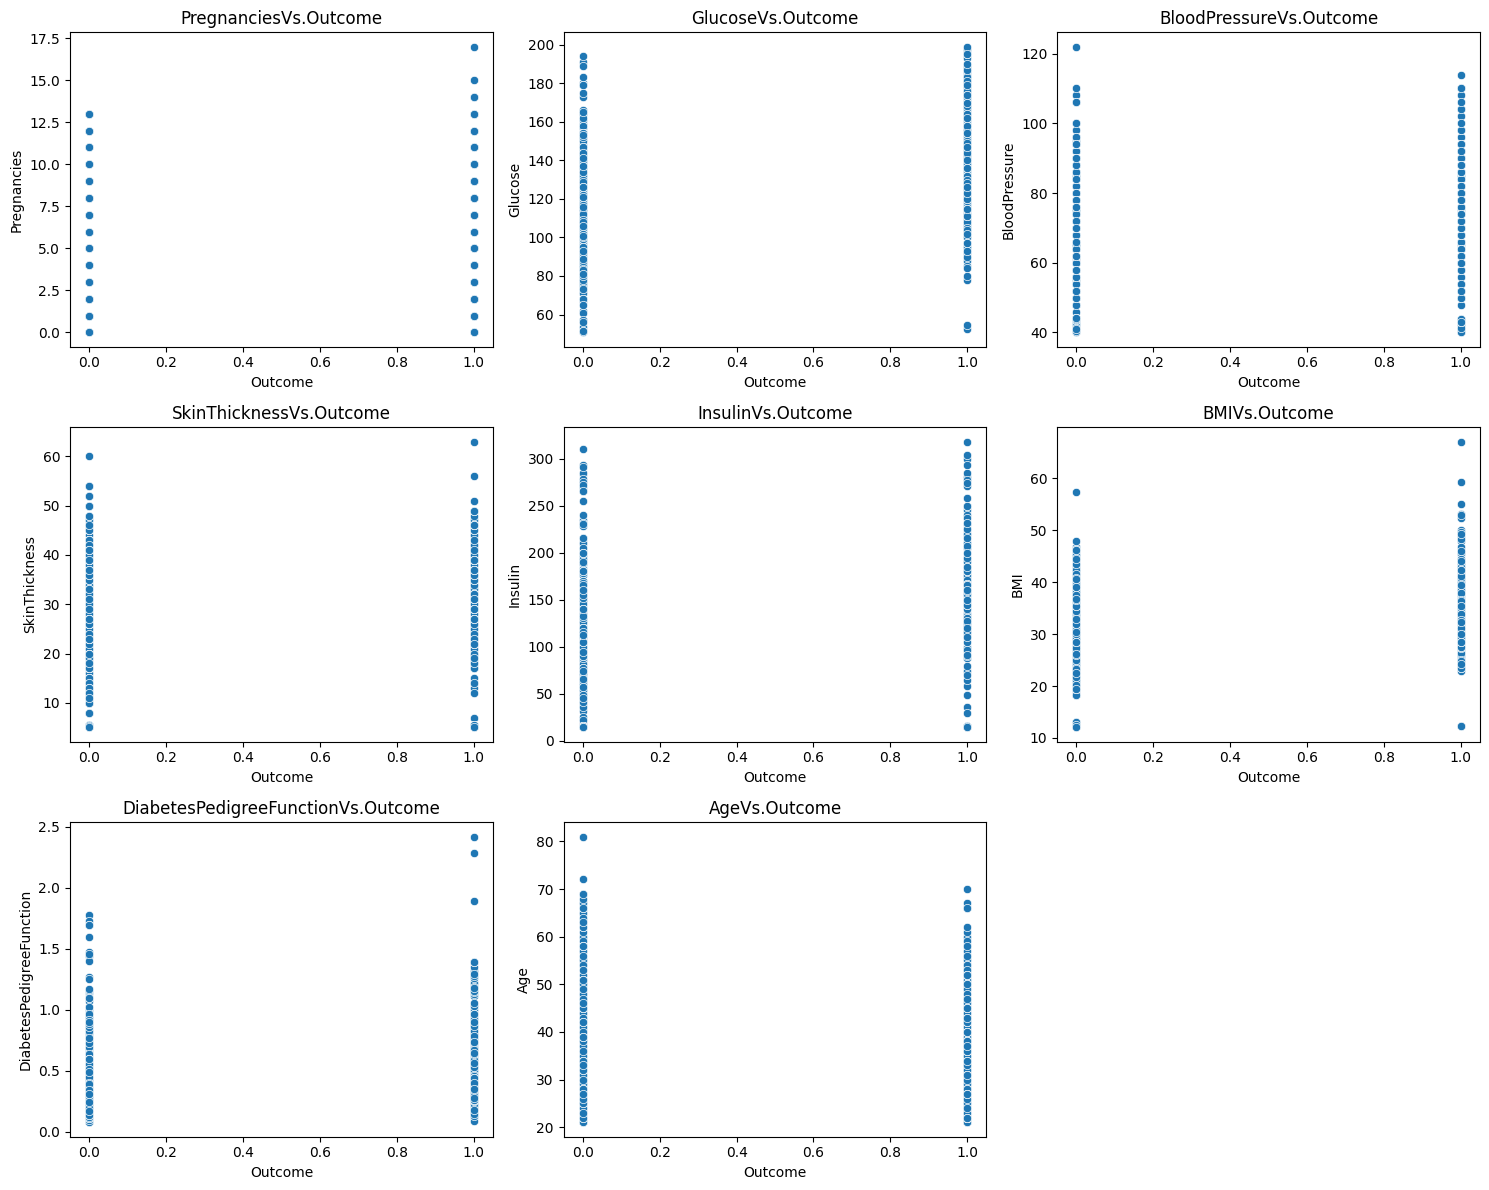

In [14]:
EDA_scatterPlots(df)

In [15]:
#correlation matrix:
num_cols=df.drop("Outcome",axis=1).select_dtypes("number")
num_cols.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.150679,0.191467,-0.069071,-0.087250,0.025090,-0.036451,0.544400
Glucose,0.150679,1.000000,0.225330,0.018140,0.241490,0.227435,0.113703,0.277179
BloodPressure,0.191467,0.225330,1.000000,0.140006,0.039460,0.291165,0.020787,0.318544
SkinThickness,-0.069071,0.018140,0.140006,1.000000,0.465237,0.425895,0.172380,-0.120482
Insulin,-0.087250,0.241490,0.039460,0.465237,1.000000,0.204484,0.185367,-0.080657
BMI,0.025090,0.227435,0.291165,0.425895,0.204484,1.000000,0.152664,0.044457
DiabetesPedigreeFunction,-0.036451,0.113703,0.020787,0.172380,0.185367,0.152664,1.000000,0.041412
Age,0.544400,0.277179,0.318544,-0.120482,-0.080657,0.044457,0.041412,1.000000


<Axes: >

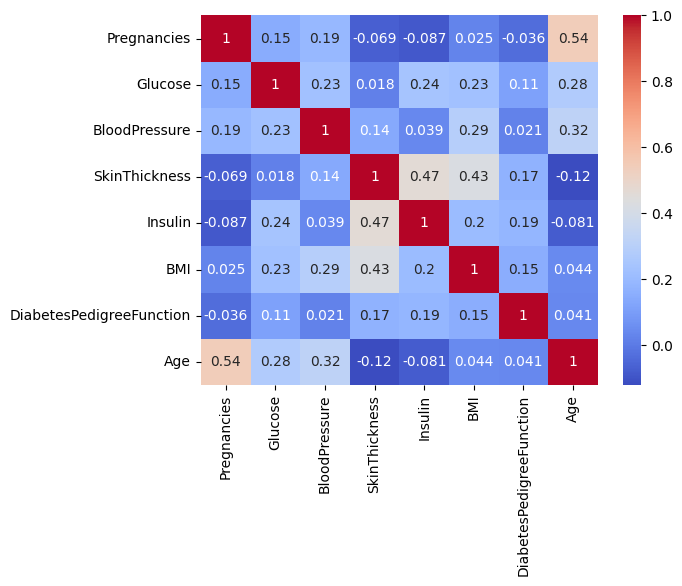

In [16]:
#Correlation Heatmap:
sns.heatmap(num_cols.corr(),annot=True,cmap="coolwarm")


In [ ]:

def advanced_eda(df):
    # Pairplot for feature relationships
    sns.pairplot(df, hue='Outcome')

    # Feature distributions by outcome
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    features = df.drop('Outcome', axis=1).columns

    for i, feature in enumerate(features):
        row, col = i//4, i%4
        sns.violinplot(data=df, x='Outcome', y=feature, ax=axes[row, col])
    plt.legend()
    plt.tight_layout()
    plt.show()

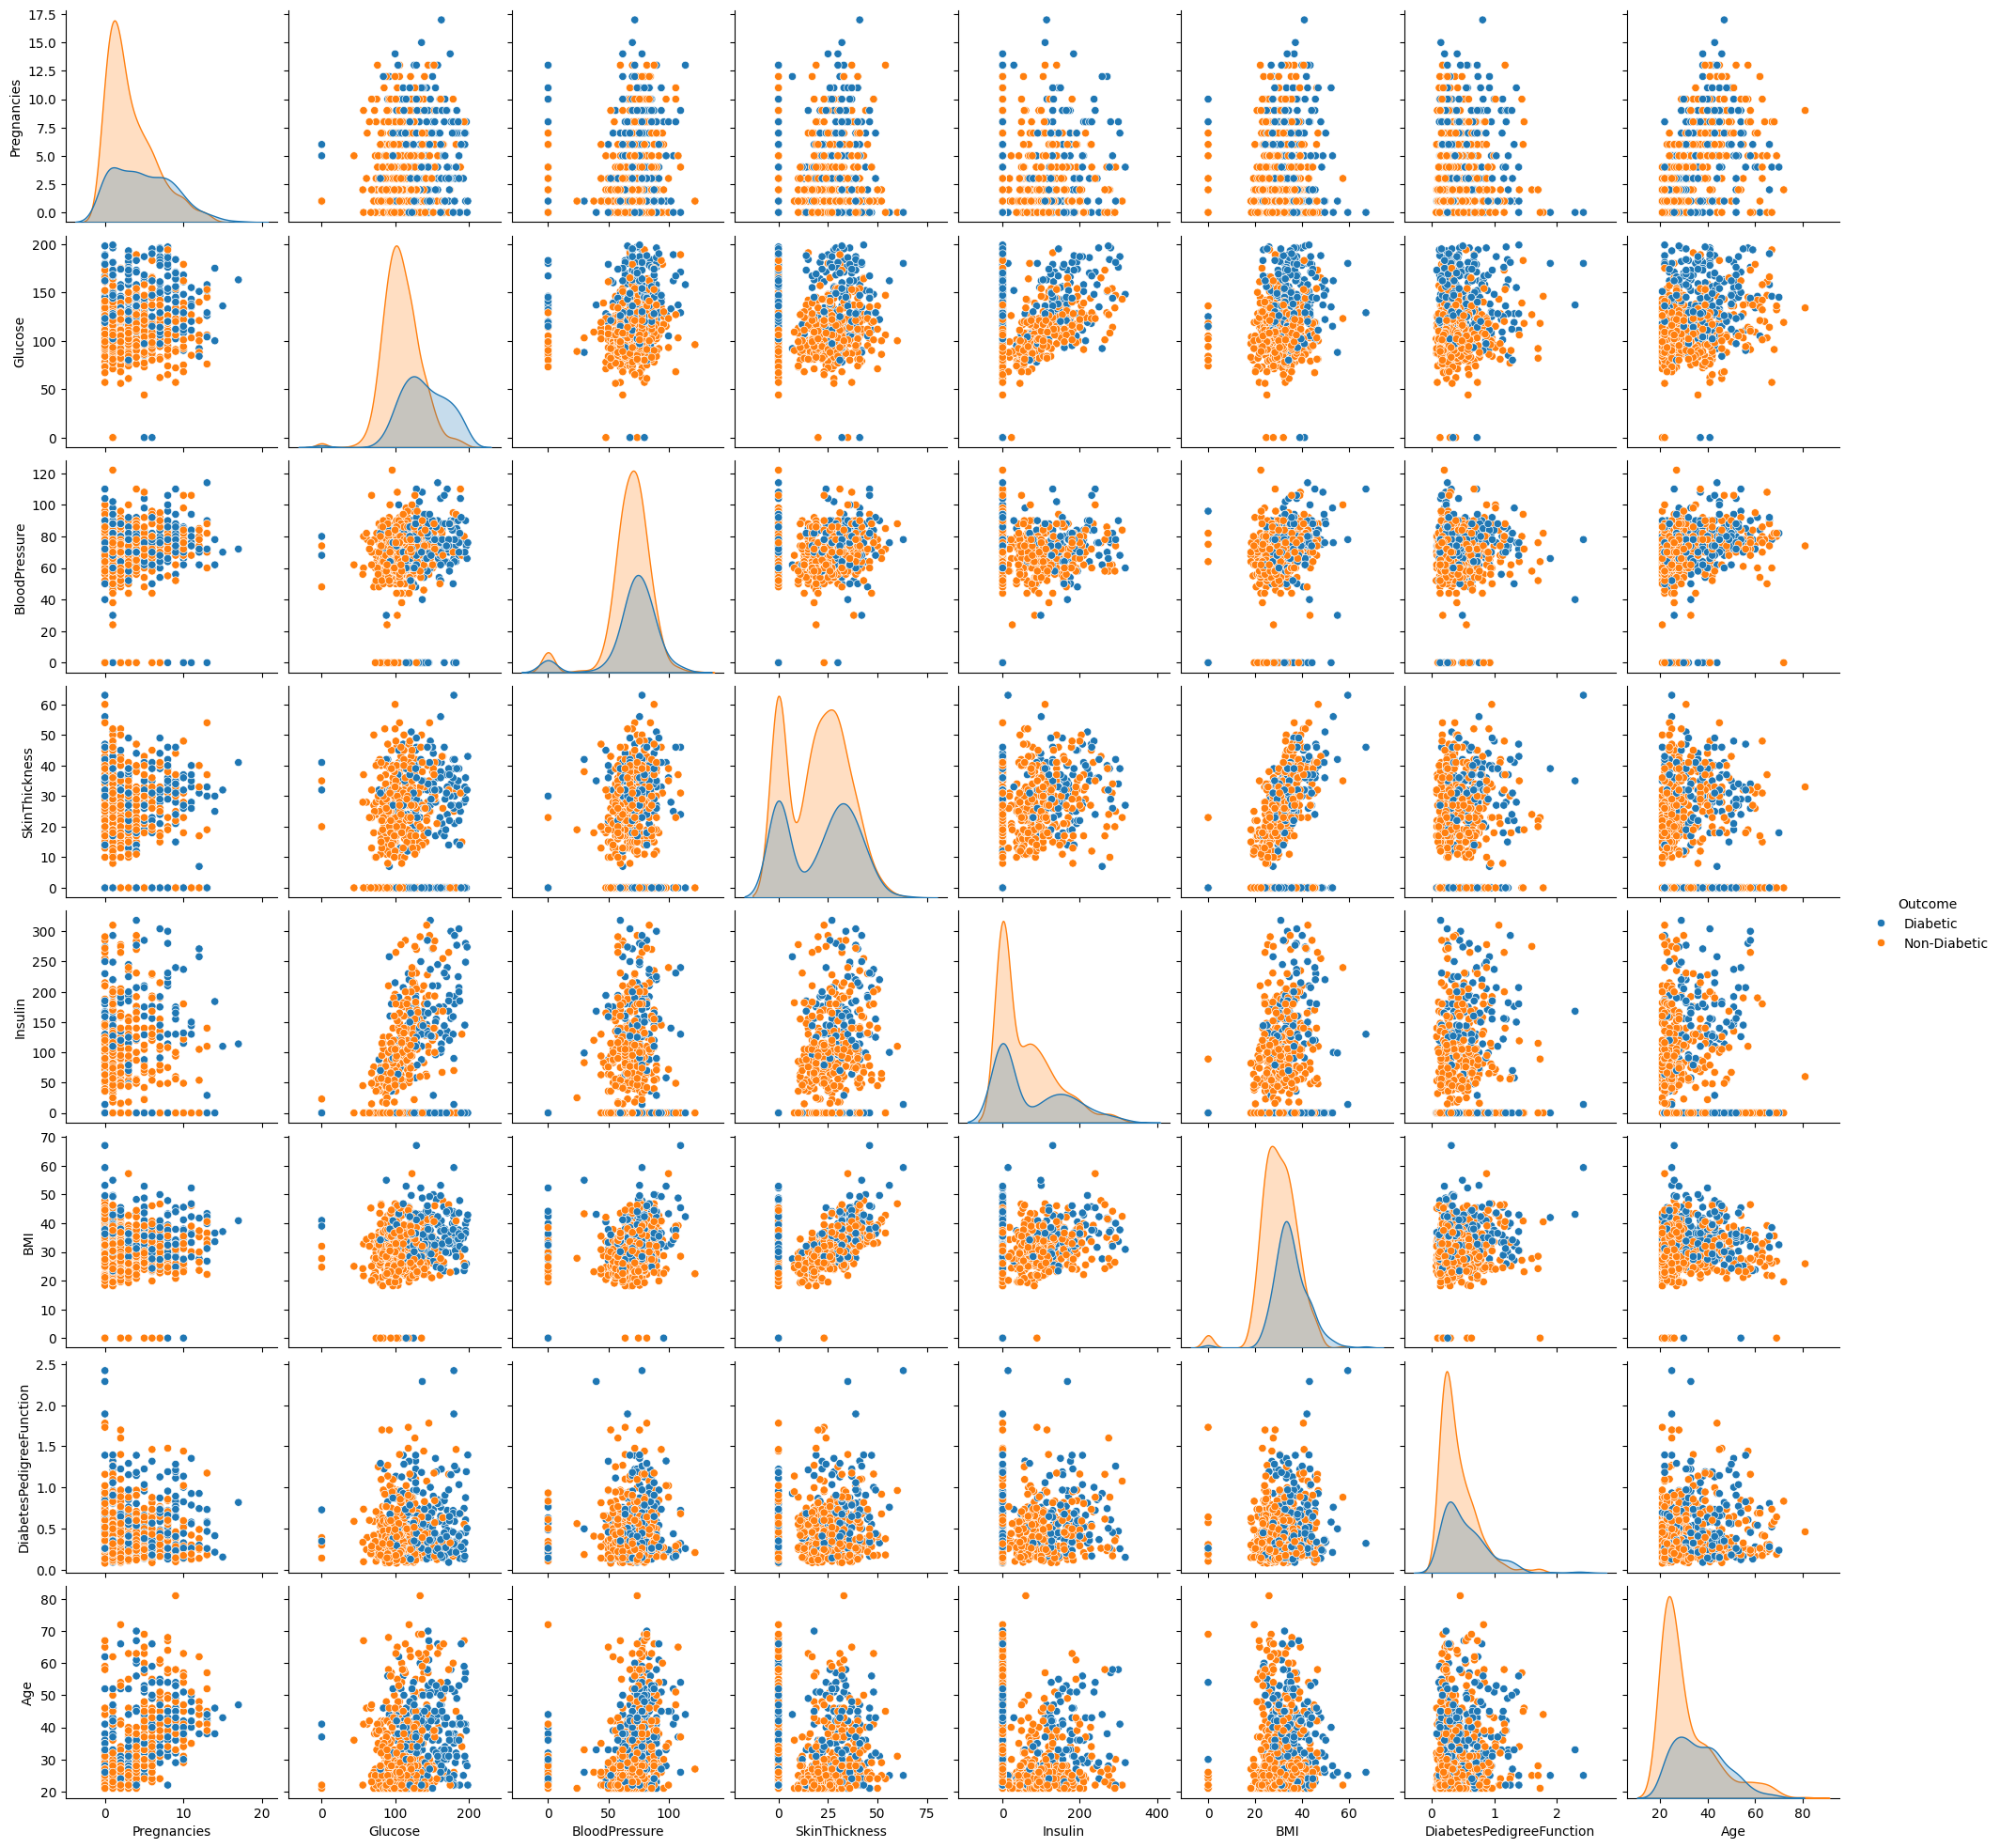

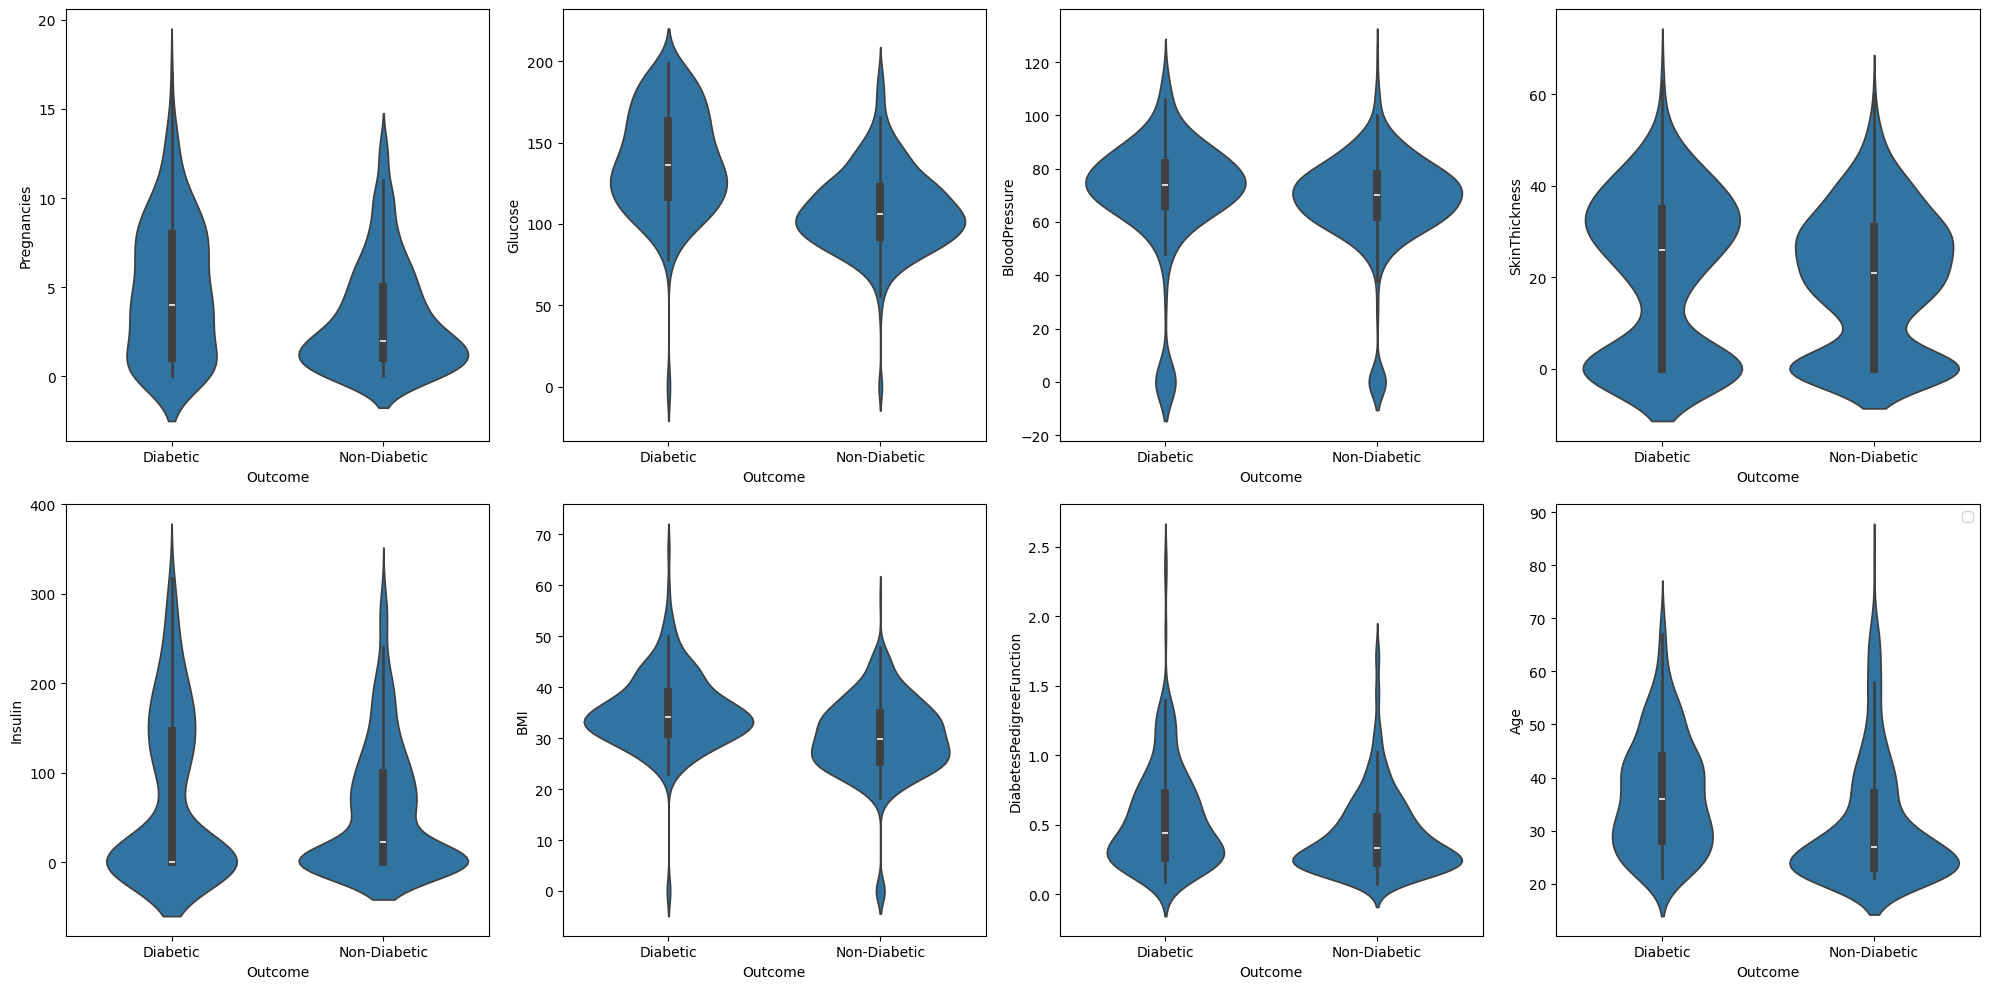

In [ ]:
advanced_eda(df)

In [18]:
def Data_Spliting_scaling(df):
  X=df.drop("Outcome",axis=1)
  y=df["Outcome"]
  Categorical_data=X.select_dtypes("object")
  if len(Categorical_data)>0:
    LE=LabelEncoder()
    for col in Categorical_data.columns:
      X[col]=LE.fit_transform(X[col])
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
  Scaler=StandardScaler()
  X_train=Scaler.fit_transform(X_train)
  X_test=Scaler.fit_transform(X_test)
  return X_train,X_test,y_train,y_test



In [22]:
X_train,X_test,y_train,y_test=Data_Spliting_scaling(df)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((586, 8), (147, 8), (586,), (147,))

In [33]:
def save_to_pickle(df, X_train, X_test, y_train, y_test, filename="preprocessing_results.pkl"):
  preprocessing_data = {
        'processed_dataframe': df,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': StandardScaler,
        'imputer': LabelEncoder,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'train_shape': X_train.shape,
        'test_shape': X_test.shape
    }
  with open(filename,"wb") as f:
    pickle.dump(preprocessing_data,f)

  print(f"All preprocessing results saved to {filename}")
  print(f"File size: {os.path.getsize(filename) / 1024:.2f} KB")



In [34]:
save_to_pickle(df, X_train, X_test, y_train, y_test, filename="preprocessing_results.pkl")

All preprocessing results saved to preprocessing_results.pkl
File size: 122.33 KB


In [35]:
def load_preprocessing_results_pickle(filename="preprocessing_results.pkl"):

    with open(filename, 'rb') as f:
        data = pickle.load(f)

    print(f"Data loaded from {filename}")
    print(f"Saved on: {data['timestamp']}")
    print(f"Training data shape: {data['train_shape']}")
    print(f"Test data shape: {data['test_shape']}")

    return (data['processed_dataframe'], data['X_train'], data['X_test'],
            data['y_train'], data['y_test'], data['scaler'], data['imputer'])

In [36]:
load_preprocessing_results_pickle()

Data loaded from preprocessing_results.pkl
Saved on: 2025-07-22 15:30:11
Training data shape: (586, 8)
Test data shape: (147, 8)


(     Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
 0            6.0    148.0           72.0      35.000000   14.385681  33.6   
 1            1.0     85.0           66.0      29.000000   14.210107  26.6   
 2            8.0    183.0           64.0       5.458330   15.248268  23.3   
 3            1.0     89.0           66.0      23.000000   94.000000  28.1   
 4            0.0    137.0           40.0      35.000000  168.000000  43.1   
 ..           ...      ...            ...            ...         ...   ...   
 763         10.0    101.0           76.0      48.000000  180.000000  32.9   
 764          2.0    122.0           70.0      27.000000   14.425590  36.8   
 765          5.0    121.0           72.0      23.000000  112.000000  26.2   
 766          1.0    126.0           60.0       5.034891   14.253014  30.1   
 767          1.0     93.0           70.0      31.000000   14.026641  30.4   
 
      DiabetesPedigreeFunction   Age  Outcome  
 0            